# Expected Goals
This is a concept which translates position on the field to probability of scoring from the location.  The basis for the probability is the angle from the position to the posts of the goal.  The pattern has been validated based on actual shooting data from various leagues which demonstrate a very consistent outcome for actual shots taken, especially when removing outlier locations.

### Imports
The imports required to conduct the expected goals modeling is more in depth that the prior lessons.  This is driven by the data location and the statistical methods applied.

In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import json
# plotting
import matplotlib.pyplot as plt
from mplsoccer import VerticalPitch
# statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf
#opening data
import os
import pathlib
import warnings

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

## Opening data
The Expected Goals (xG) model will use Wyscout data. To meet file size requirements for Github the files were stored in multiple smaller files. For this example the files were saved locally, so here they will be loaded from the directory.

In [2]:
#load data - store it in train dataframe
train = pd.DataFrame()
with open('./data/events_England.json') as f:
    data = json.load(f)
    train = pd.DataFrame(data)

In [3]:
# train['positions'][0][0]['x']
train.head(2)

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172


## Preparing data
Exepcted goals model is built using only shots, so the data will be filtered for those events. 
- Query the data for only those actions for which the subEventName was Shot. **Note that this way penalties are excluded which wouldn’t be a case if we used only eventName.** 
- Store the coordinates of each shot transformed to 105 x 68 pitch. This will require some conversions. Treat the goal as x = 0. 
- Created C is an auxillary variable to help calculate the distance and angle. It is the distance from a point to the horizontal line through the middle of the pitch. 
- Calculate the distance to the goal as the distance on a Euclidean plane (see Distance in R2). Determine the angle using the formula from The Geometry of Shooting. 
- Maintain the data on if a goal was scored as part of the dataframe. It can be found in the tags column - if in this column exists {id: 101}.

In [4]:
# Filter dataframe for shots
shots = (train
 .query('subEventName == "Shot"')
 .assign(X = lambda df: df.positions.apply(lambda cell: (100 - cell[0]['x']) * 105/100),
         Y = lambda df: df.positions.apply(lambda cell: cell[0]['y']* 68/100),
         C = lambda df: df.positions.apply(lambda cell: abs(cell[0]['y'] - 50) * 68/100),
         Distance = lambda df: np.sqrt(df.X**2 + df.C**2),
         Angle = lambda df: np.where(np.arctan(7.32 * df["X"] / (df["X"]**2 + 
                                                                    df["C"]**2 - (7.32/2)**2)) > 0, 
                                     np.arctan(7.32 * df["X"] /(df["X"]**2 + df["C"]**2 - (7.32/2)**2)), 
                                     np.arctan(7.32 * df["X"] /(df["X"]**2 + df["C"]**2 - (7.32/2)**2)) 
                                     + np.pi),
         Goal = lambda df: df.tags.apply(lambda x: 1 if {'id':101} in x else 0).astype(object)
        )
)

In [5]:
shots.head(2)

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,X,Y,C,Distance,Angle,Goal
46,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",25413,"[{'y': 41, 'x': 88}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,94.595788,100,177959212,12.60,27.88,6.12,14.007655,0.467241,1
62,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1211}, {'id'...",26150,"[{'y': 52, 'x': 85}, {'y': 100, 'x': 100}]",2499719,Shot,1631,1H,179.854785,100,177959247,15.75,35.36,1.36,15.808608,0.453557,0


## Plotting shot location
Investigating the relationship between shot location and goal location requires creation of a heat map of all shots from the 2017/18 Premier League season.  This will then be compared to the same heat map for the actual goals, and subsequently, the ratio of goals to shots taken will provide the initial view of expected goals.  This will then be converted into a mathmatical relationship based on the shot angle.  There are three shot 2D histogram plots shown below:
- Shots taken 2D histogram
- Shots scored 2D histogram
- Shot percent score 2D histogram (goals at location/shots at location)

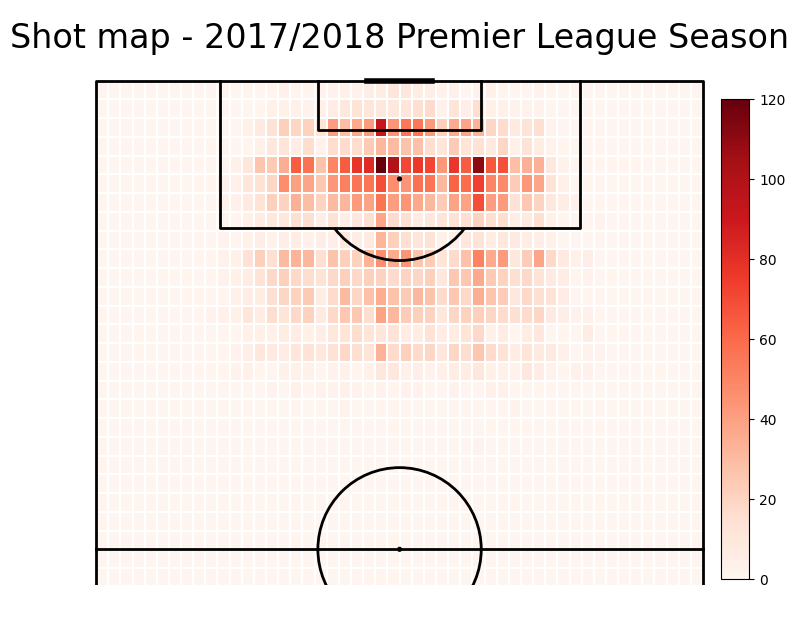

In [6]:
# plot pitch
pitch = VerticalPitch(line_color='black', half = True, 
                      pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, figheight=6,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# subtracting x from 105 but not y from 68 because of inverted Wyscout axis
# calculate number of shots in each bin
bin_statistic_shots = pitch.bin_statistic(105 - shots.X, shots.Y, bins=50)

# make heatmap
pcm = pitch.heatmap(bin_statistic_shots, 
                    ax=ax["pitch"], cmap='Reds', edgecolor='white', linewidth = 0.01)

# make legend
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shot map - 2017/2018 Premier League Season' , fontsize = 24)
plt.show()

## Plotting goal location
Continuing the process to depict the location where goals were scored in open play.  To achieve this, the same shots approach will be used, however it will be filtered to show only opportunities which resulted in goals.

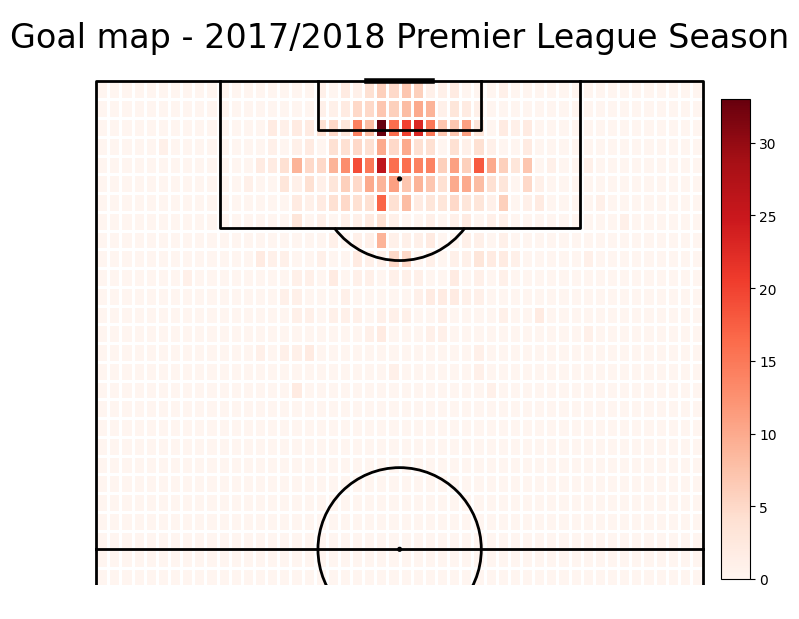

In [7]:
#take only goals
goals = shots.loc[shots["Goal"] == 1]
#plot pitch
pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, figheight=6,
                     endnote_height=0.04, title_space=0, endnote_space=0)

#calculate number of goals in each bin
bin_statistic_goals = pitch.bin_statistic(105 - goals.X, goals.Y, bins=50)

#plot heatmap
pcm = pitch.heatmap(bin_statistic_goals, ax=ax["pitch"], cmap='Reds', edgecolor='white')

#make legend
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal map - 2017/2018 Premier League Season' , fontsize = 24)
plt.show()

## Plotting the probability of scoring at a given shot location
Based on these two pieces of information it is possible to calculate the proportion of goals scored from each bin to number of shots from that location.  This provides a measured view of the expected goal model.

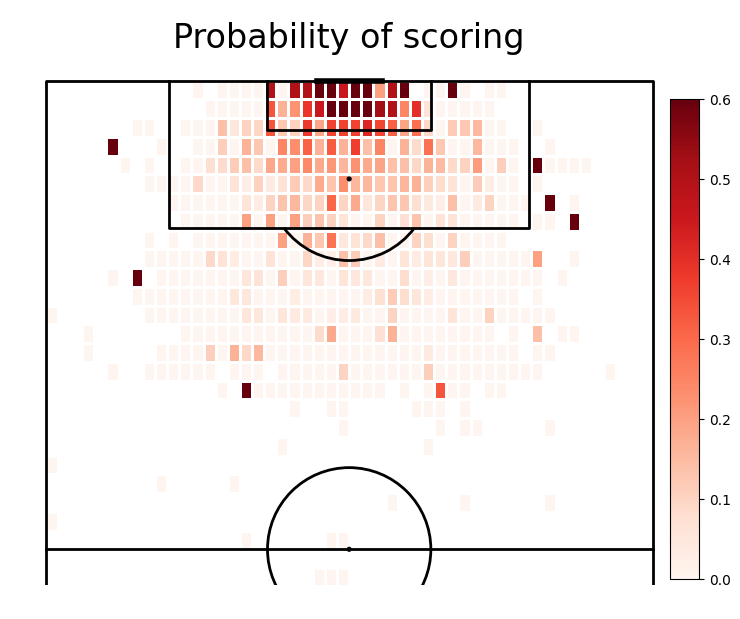

In [8]:
#plot pitch
pitch = VerticalPitch(line_color='black', half = True, 
                      pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, figheight=6,
                     endnote_height=0.04, title_space=0, endnote_space=0)

bin_statistic = pitch.bin_statistic(105 - shots.X, shots.Y, bins = 50)

#normalize number of goals by number of shots
bin_statistic["statistic"] = bin_statistic_goals["statistic"]/bin_statistic["statistic"]

#plot heatmap
pcm = pitch.heatmap(bin_statistic, ax=ax["pitch"], cmap='Reds', edgecolor='white', vmin = 0, vmax = 0.6)

#make legend
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Probability of scoring' , fontsize = 24)
plt.show()

## Plotting a logistic curve
The logistic curve which is the basis for logistic regresssion helps in modeling a phenomenon which has a binary outcome.  In the case of shootting location, this curve will predict the likelyhood of scoring (outcome 1.0) or missing (outcome 0.0), which most often will fall between 1 and 0 as a probability.  Below is a plot if the logistic curve formulation.  
- L = curve max value
- $x$ = curve x values
- $b_0$ = intersect at zero
- $b_1$ = coefficient, and growth rate for simple model

$$ \frac{L}{1 + e^{(b_0 + b_1 \cdot x)}} $$

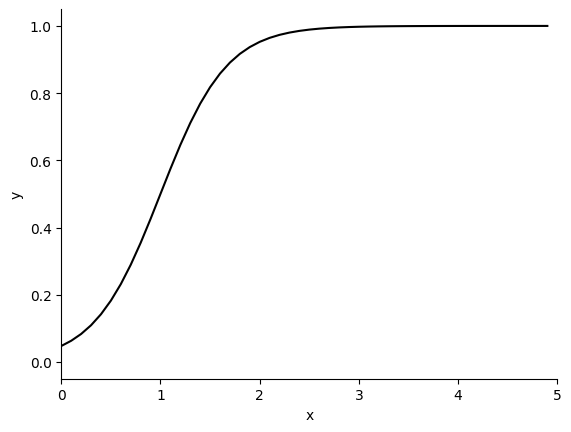

In [9]:
b = [3, -3]
x = np.arange(5, step=0.1)
y = 1/(1+np.exp(b[0]+b[1]*x)) # logisitc formula

fig,ax = plt.subplots()
plt.ylim((-0.05,1.05))
plt.xlim((0,5))
ax.set_ylabel('y')
ax.set_xlabel("x")
ax.plot(x, y, linestyle='solid', color='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

## Investigating the relationship between goals and shot angle
The base hypothesis is that the narrower that shot angle from the shooting position toward the goal posts, the less likely a shooter is to score.  To understand this relationship, the current shot position data must be converted into an equivalent shooting angle.  This will then be plotted along with the scoring result.

In [10]:
shots.head(2) # angle is the second to last column in radians 

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,X,Y,C,Distance,Angle,Goal
46,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",25413,"[{'y': 41, 'x': 88}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,94.595788,100,177959212,12.60,27.88,6.12,14.007655,0.467241,1
62,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1211}, {'id'...",26150,"[{'y': 52, 'x': 85}, {'y': 100, 'x': 100}]",2499719,Shot,1631,1H,179.854785,100,177959247,15.75,35.36,1.36,15.808608,0.453557,0


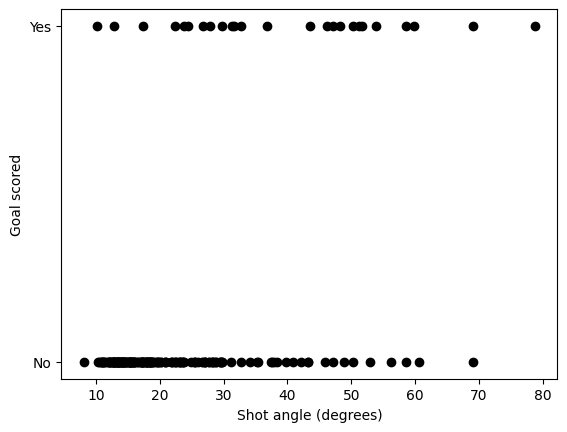

In [11]:
#first 200 shots
shots_200=shots.iloc[:200]

#plot first 200 shots goal angle, using base plot and building up desired output
fig, ax = plt.subplots()
ax.plot(shots_200['Angle']*180/np.pi, shots_200['Goal'], linestyle='none', marker= '.', markersize= 12, color='black')

#make legend
ax.set_ylabel('Goal scored')
ax.set_xlabel("Shot angle (degrees)")
plt.ylim((-0.05,1.05))
ax.set_yticks([0,1])
ax.set_yticklabels(['No','Yes'])
plt.show()

## Investigating the relationship between probability of scoring goals and angle
After seeing the outcome of goals versus angle, the next view is probability of scoring versus angle.  The desired output is a scatter plot showing probability of scoring versus the angle of the shot.  It is anticipated that these two variables would be positively correlated.  

In [12]:
np.histogram(shots.Angle*(180/np.pi), bins=60, range=[0,180])

(array([   3,   21,   89,  545, 1660, 1482,  940,  639,  590,  546,  353,
         323,  233,  185,  118,  154,   86,  106,   46,   44,   60,   22,
          18,   52,   10,    0,   25,   28,    0,   12,    0,   15,   17,
           0,    0,    2,    0,    0,   10,    7,    4,    0,    0,    0,
           0,    0,    0,    3,    2,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    1]),
 array([  0.,   3.,   6.,   9.,  12.,  15.,  18.,  21.,  24.,  27.,  30.,
         33.,  36.,  39.,  42.,  45.,  48.,  51.,  54.,  57.,  60.,  63.,
         66.,  69.,  72.,  75.,  78.,  81.,  84.,  87.,  90.,  93.,  96.,
         99., 102., 105., 108., 111., 114., 117., 120., 123., 126., 129.,
        132., 135., 138., 141., 144., 147., 150., 153., 156., 159., 162.,
        165., 168., 171., 174., 177., 180.]))

In [13]:
# number of shots from angle
shotcount_dist = np.histogram(shots['Angle']*180/np.pi, bins=40, range=[0, 180])

# number of goals from angle
goalcount_dist = np.histogram(goals['Angle']*180/np.pi, bins=40, range=[0, 180])
np.seterr(divide='ignore', invalid='ignore')

# probability of scoring goal
prob_goal = np.divide(goalcount_dist[0], shotcount_dist[0])

# angle math: Not stated, but angle range is 1 element longer, so averaging the angle values agains 
# them selves to drop data away
angle = shotcount_dist[1]
midangle = (angle[:-1] + angle[1:])/2

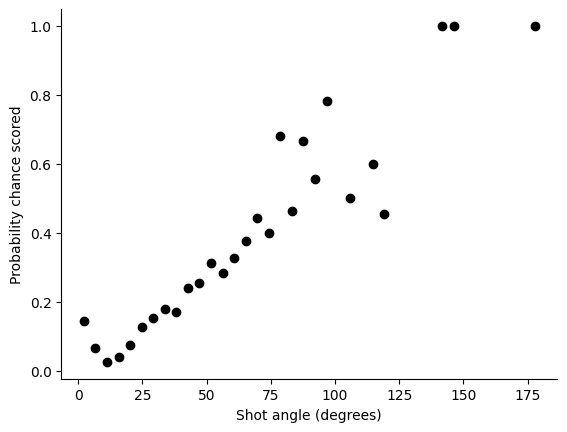

In [14]:
#make plot
fig,ax = plt.subplots()
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markersize= 12, color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Shot angle (degrees)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

## Fitting logistic regression with random coefficients
A logistic regression curve with set parameters - 3 for intercept and -3 for angle is fit to the data.  This is the same as the curve created previously. However, these are most likely not the best estimators of true parameters for the fit.  There is clearly an offset to the fit.

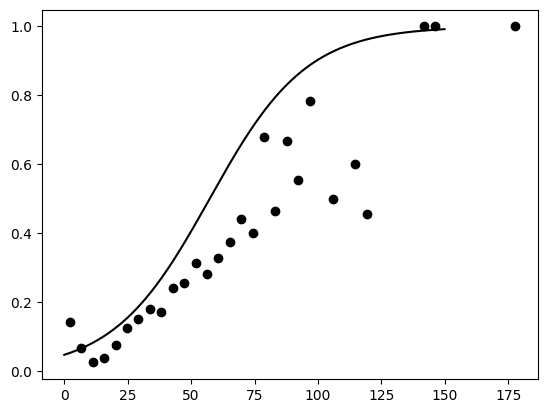

In [15]:
fig, ax = plt.subplots()

# parameters
b = [3, -3]
x = np.arange(150,step=0.1)
y = 1/(1+np.exp(b[0]+b[1]*x*np.pi/180))

# plot data
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markersize= 12, color='black')

# plot logistic function
ax.plot(x, y, linestyle='solid', color='black')
plt.show()

## Calculating log-likelihood
The best parameters are those which maximize the log-likelihood. Here, after applying the logisitc formula and leveraging the shooting angle as the x value, the log value of the calculated expected goal probability is used to calculate the log-likelihood.  After conducting some testing of the approach, it was difficult to understand why certain steps were taken.  

In [16]:
# formula for xG calculated using angle as the x variable (in radians)
xG = 1/(1+np.exp(b[0]+b[1]*shots['Angle']))
shots = shots.assign(xG = xG)
shots_40 = shots.iloc[:40]

In [17]:
(shots_40
 .iloc[:5,-1:]
 .assign(one_minus_log = lambda df: np.log(1 - df.xG))
 .assign(logval = lambda df: np.log(df.xG))
)

,xG,one_minus_log,logval
46,0.168222,-0.184190,-1.782468
62,0.162557,-0.177402,-1.816729
91,0.754979,-1.406411,-0.281065
128,0.101926,-0.107503,-2.283505
249,0.087783,-0.091878,-2.432883


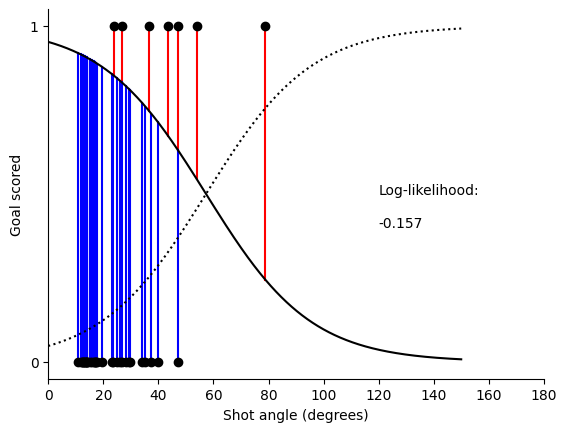

In [18]:
# plot set up
fig, ax = plt.subplots()

# plot data points
ax.plot(shots_40['Angle']*180/np.pi, shots_40['Goal'], linestyle='none', marker= '.', markersize= 12, color='black', zorder = 3)

# plot curves positive and inverted
ax.plot(x, y, linestyle=':', color='black', zorder = 2)
ax.plot(x, 1-y, linestyle='solid', color='black', zorder = 2)

# calculate loglikelihood
loglikelihood=0
for item,shot in shots_40.iterrows():
    ang = shot['Angle'] * 180/np.pi
    if shot['Goal'] == 1:
        loglikelihood=+np.log(shot['xG'])
        ax.plot([ang,ang],[shot['Goal'],1-shot['xG']], color='red', zorder = 1)
    else:
        loglikelihood=+np.log(1 - shot['xG'])
        ax.plot([ang,ang], [shot['Goal'], 1-shot['xG']], color='blue', zorder = 1)

# make legend, set plot limits, add annotation, adjust ticks, remove spines
ax.set_ylabel('Goal scored')
ax.set_xlabel("Shot angle (degrees)")
plt.ylim((-0.05,1.05))
plt.xlim((0,180))
plt.text(120,0.5,'Log-likelihood:')
plt.text(120,0.4,str(loglikelihood)[:6])
ax.set_yticks([0,1])
ax.spines[['top','right']].set_visible(False)
plt.show()

## Fitting logistic regression and finding best parameters
The best parameters are those which maximize the log-likelihood.  Here, the stats models formula (smf) api is called and the generalized linear model for regression is leveraged along with a statsmodels Binomial exponential distribution for the fit of the data leveraging the two passed variables, goals (dependent) and angle (independent).  

>**note**: There is a bit of magic here, and not being familiar with documentation or the mathmatics makes this difficult to understand.

After fitting the binomia logistic regression, the parameters are passed into the data plot, showing the improved alignment with the data in the plot.  This is a good simplified model of the probability of scoring from a given position on the pitch without accounting for many additional variables, using angle as the primary measure.

In [19]:
# create model, specifically a binomial fit against the data
test_model = smf.glm(formula="Goal ~ Angle" , data=shots,
                           family=sm.families.Binomial()).fit()
print(test_model.summary())
# get params
b=test_model.params

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 8451
Model:                                GLM   Df Residuals:                     8449
Model Family:                    Binomial   Df Model:                            1
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -2561.2
Date:                    Sun, 28 May 2023   Deviance:                       5122.5
Time:                            20:12:56   Pearson chi2:                 7.96e+03
No. Iterations:                         6   Pseudo R-squ. (CS):            0.07609
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

In [20]:
b

Intercept    3.524767
Angle       -2.843641
dtype: float64

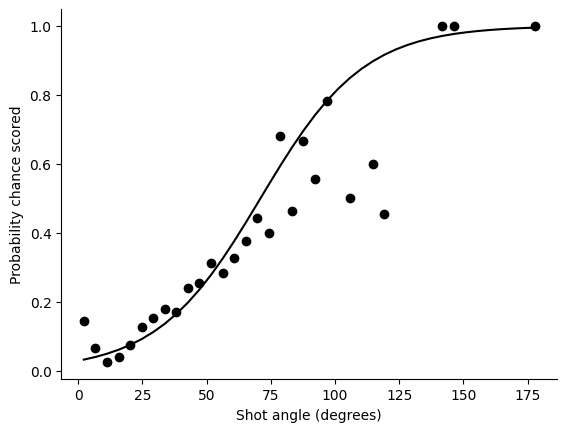

In [21]:
# recalculate xG using test model results assigned to b previously
xGprob = 1/(1+np.exp(b[0]+b[1]*midangle*np.pi/180))
fig, ax = plt.subplots()

# plot data again
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markersize= 12, color='black')

# plot line using new xG probabilities
ax.plot(midangle, xGprob, linestyle='solid', color='black')

# make legend, remove spines
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Shot angle (degrees)")
ax.spines[['top','right']].set_visible(False)
plt.show()

## Investigating the relationship between probability of scoring goals and distance to goal
To find out if the distanse influences the probability of scoring a goal plot the probability of scoring given the distance. Then fit a logistic regression model to the data and compare to the prior model values for $R^2$.

In [22]:
# create a distribution for number of shots vs distance from goal
shotcount_dist = np.histogram(shots['Distance'],bins=40,range=[0, shots.Distance.max()])

# create a distribution for number of goals vs distance from goal
goalcount_dist = np.histogram(goals['Distance'],bins=40,range=[0, shots.Distance.max()])

# empirical probability of scoring (Goals:Shots in each bin)
prob_goal = np.divide(goalcount_dist[0],shotcount_dist[0])

# bin dimension adjustment
distance = shotcount_dist[1]
middistance= (distance[:-1] + distance[1:])/2

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 8451
Model:                                GLM   Df Residuals:                     8449
Model Family:                    Binomial   Df Model:                            1
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -2524.4
Date:                    Sun, 28 May 2023   Deviance:                       5048.9
Time:                            20:12:57   Pearson chi2:                 1.56e+04
No. Iterations:                         6   Pseudo R-squ. (CS):            0.08410
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

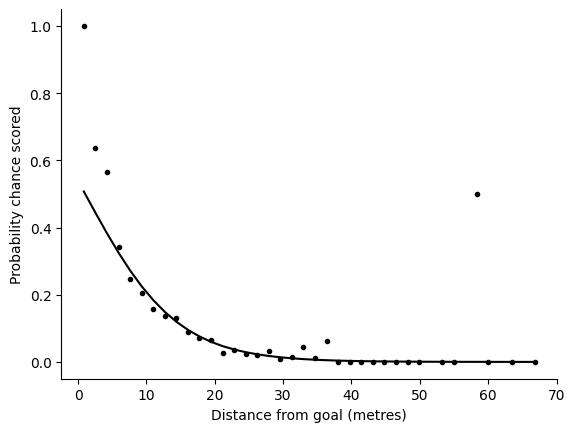

In [23]:
# making a plot
fig, ax = plt.subplots()

# plotting data
ax.plot(middistance, prob_goal, linestyle='none', marker= '.', color='black')

# making legend, turn off spines
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Distance from goal (metres)")
ax.spines[['top','right']].set_visible(False)

# make single variable model of distance, simple relationship like angle using binomial fit
test_model = smf.glm(formula="Goal ~ Distance" , data=shots,
                           family=sm.families.Binomial()).fit()

# print summary, assign coefficients (b)
print(test_model.summary())
b=test_model.params

# recalculate xG with new coefficients based on model fit to the data
xGprob=1/(1+np.exp(b[0]+b[1]*middistance))

# plot new model line on top of the data
ax.plot(middistance, xGprob, linestyle='solid', color='black')
plt.show()

## Adding squared distance to the distance model
To further evaluate and potentially improve the model an effort can be made to add more variables(features).  While one variable models are robust in their ability to be easily translated, they are difficult to achieve a high level of accuracy with for anything but the simplest of data sets. 

>**Caution**: adding features which are already accounted for in the existing data often do not help in improving the prediction because they are not truly independent variables.

Moving to a model based on both distance and distance squared might help to capture that outlier (see the problem?). The varaibale for distance and distance squared is leveraged to determine if it improves the prediction for likelihood to score.

In [24]:
# calculating distance squared
shots["D2"] = shots['Distance']**2

# adding it to the model
test_model = smf.glm(formula="Goal ~ Distance + D2" , data=shots,
                           family=sm.families.Binomial()).fit()
# print model summary and set parameters
print(test_model.summary())
b=test_model.params

# recalculate xG based on new parameters, notice added structure for new parameter structure
xGprob=1/(1+np.exp(b[0]+b[1]*middistance+b[2]*pow(middistance,2)))

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 8451
Model:                                GLM   Df Residuals:                     8448
Model Family:                    Binomial   Df Model:                            2
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -2505.6
Date:                    Sun, 28 May 2023   Deviance:                       5011.1
Time:                            20:12:57   Pearson chi2:                 8.44e+03
No. Iterations:                         7   Pseudo R-squ. (CS):            0.08818
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

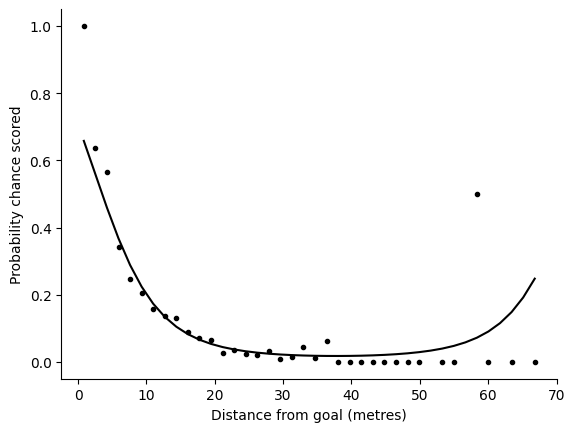

In [25]:
fig, ax = plt.subplots()
#plot line
ax.plot(middistance, prob_goal, linestyle='none', marker= '.', color='black')
#make legend
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Distance from goal (metres)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.plot(middistance, xGprob, linestyle='solid', color='black')
plt.show()

## Adding squared distance to the model
For a model more variables/feature can be leveraged simultaneously to assist with fitting the model to the observed phenomenon. Again, the priod warning about features which are not truly independent is valid and should be considered.  In addition, simplicity generally wins out.  Overfitting tends to occur as complexity increases, and thus continuing to add features can have and adverse affect in the process is not well understood.  

Creating and adding additional variables to the model is called feature engineering.  It is something which requires experience and testing to understand in detail.  In the below model, distance to goal squared $D^2$, $X^2$, $C^2$ and $angle \cdot X$ is added for fine tuning and increased accuracy.  Let's see if it improves the predictions.

In [26]:
# Add variables to the dataframe with assignment calls
shots["X2"] = shots['X']**2
shots["C2"] = shots['C']**2
shots["AX"]  = shots['Angle']*shots['X']

# list the model variables you want here
model_variables = ['Angle','Distance','X','C', "X2", "C2", "AX"]
model=''
for v in model_variables[:-1]:
    model = model  + v + ' + '
model = model + model_variables[-1]

model # not real complicated in the end

'Angle + Distance + X + C + X2 + C2 + AX'

---

Notice that the derived model is simply an addition of all the created paramters.  This is then placed into a binomial fit with a similar accuracy or $R^2$ value (0.089 or 8.9%).  Slightly improved, but not substantially over the simpler angle and distance based models.

In [27]:
# fit the created model
test_model = smf.glm(formula="Goal ~ " + model, data=shots,
                           family=sm.families.Binomial()).fit()
# print summary and assign paramters
print(test_model.summary())
b=test_model.params

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 8451
Model:                                GLM   Df Residuals:                     8443
Model Family:                    Binomial   Df Model:                            7
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -2498.7
Date:                    Sun, 28 May 2023   Deviance:                       4997.4
Time:                            20:12:57   Pearson chi2:                 8.40e+03
No. Iterations:                         7   Pseudo R-squ. (CS):            0.08966
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

In [28]:
# create formula to return xG for the more general model
def calculate_xG(sh):
    bsum = b[0]
    for i,v in enumerate(model_variables):
        bsum=bsum+b[i+1]*sh[v]
    xG = 1/(1+np.exp(bsum))
    return xG

In [29]:
# add an xG to my dataframe using formula and existing values
shots = shots.assign(xG=shots.apply(calculate_xG, axis=1))

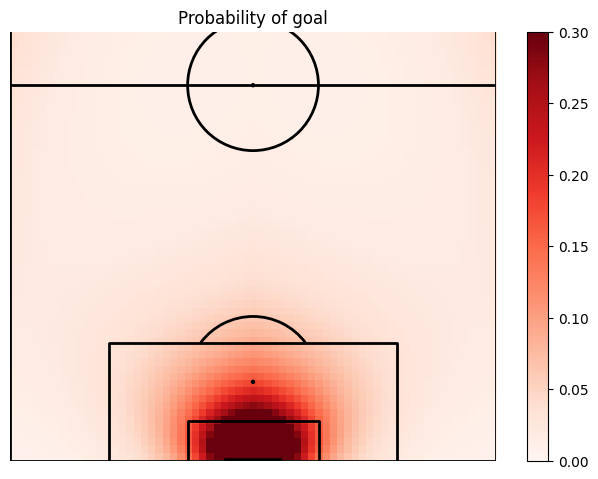

In [30]:
# Create a 2D map of xG with new parameters applied
pgoal_2d=np.zeros((68,68))
for x in range(68): # width of the field?
    for y in range(68):
        sh=dict()
        a = np.arctan(7.32 *x /(x**2 + abs(y-68/2)**2 - (7.32/2)**2))
        if a<0:
            a = np.pi + a
        sh['Angle'] = a
        sh['Distance'] = np.sqrt(x**2 + abs(y-68/2)**2)
        sh['D2'] = x**2 + abs(y-68/2)**2
        sh['X'] = x
        sh['AX'] = x*a
        sh['X2'] = x**2
        sh['C'] = abs(y-68/2)
        sh['C2'] = (y-68/2)**2

        pgoal_2d[x,y] =  calculate_xG(sh)

# plot pitch
pitch = VerticalPitch(line_color='black', half = True, 
                      pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.draw()

# plot probability
pos = ax.imshow(pgoal_2d, extent=[-1,68,68,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.3, zorder = 1)
fig.colorbar(pos, ax=ax)

# make legend, set lims, set aspect
ax.set_title('Probability of goal')
plt.xlim((0,68))
plt.ylim((0,60))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## Testing model fit
Every model must be tested to validate fit. Test the derived logistic regression model using Mcfaddens Rsquared and ROC curve.  These are statistics based model fit evaluations.

In [31]:
# Mcfaddens Rsquared for Logistic regression
null_model = smf.glm(formula="Goal ~ 1 ", data=shots,
                     family=sm.families.Binomial()).fit()
print("Mcfaddens Rsquared", 1 - test_model.llf / null_model.llf)

# ROC curve
numobs = 100
TP = np.zeros(numobs)
FP = np.zeros(numobs)
TN = np.zeros(numobs)
FN = np.zeros(numobs)

for i, threshold in enumerate(np.arange(0, 1, 1 / numobs)):
    for j, shot in shots.iterrows():
        if (shot['Goal'] == 1):
            if (shot['xG'] > threshold):
                TP[i] = TP[i] + 1
            else:
                FN[i] = FN[i] + 1
        if (shot['Goal'] == 0):
            if (shot['xG'] > threshold):
                FP[i] = FP[i] + 1
            else:
                TN[i] = TN[i] + 1

Mcfaddens Rsquared 0.13708006325049116


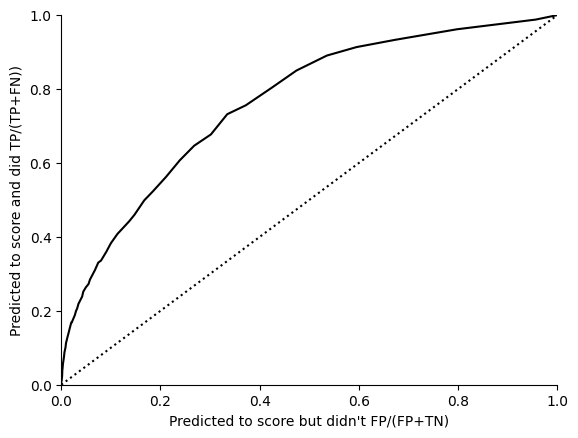

In [32]:
# Plot evaluation curves
fig, ax = plt.subplots()
ax.plot(FP / (FP + TN), TP / (TP + FN), color='black')
ax.plot([0, 1], [0, 1], linestyle='dotted', color='black')
ax.set_ylabel("Predicted to score and did TP/(TP+FN))")
ax.set_xlabel("Predicted to score but didn't FP/(FP+TN)")
plt.ylim((0.00, 1.00))
plt.xlim((0.00, 1.00))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

## Challenge
1. Create different models for headers and non-headers (as suggested in Measuring the Effectiveness of Playing Strategies at Soccer, Pollard (1997))!
2. Assign to penalties xG = 0.8!
3. Find out which player had the highest xG in 2017/18 Premier League season!

In [45]:
# Filter dataframe for shots where type is header
(train
 .query('subEventName.isin(["Shot","Penalty","Free kick shot"])')
 .assign(X = lambda df: df.positions.apply(lambda cell: (100 - cell[0]['x']) * 105/100),
         Y = lambda df: df.positions.apply(lambda cell: cell[0]['y']* 68/100),
         C = lambda df: df.positions.apply(lambda cell: abs(cell[0]['y'] - 50) * 68/100),
         Distance = lambda df: np.sqrt(df.X**2 + df.C**2),
         Angle = lambda df: np.where(np.arctan(7.32 * df["X"] / (df["X"]**2 + 
                                                                    df["C"]**2 - (7.32/2)**2)) > 0, 
                                     np.arctan(7.32 * df["X"] /(df["X"]**2 + df["C"]**2 - (7.32/2)**2)), 
                                     np.arctan(7.32 * df["X"] /(df["X"]**2 + df["C"]**2 - (7.32/2)**2)) 
                                     + np.pi),
         Goal = lambda df: df.tags.apply(lambda x: 1 if {'id':101} in x else 0).astype(object)
        )
).head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,X,Y,C,Distance,Angle,Goal
46,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",25413,"[{'y': 41, 'x': 88}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,94.595788,100,177959212,12.60,27.88,6.12,14.007655,0.467241,1
62,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1211}, {'id'...",26150,"[{'y': 52, 'x': 85}, {'y': 100, 'x': 100}]",2499719,Shot,1631,1H,179.854785,100,177959247,15.75,35.36,1.36,15.808608,0.453557,0
91,10,Shot,"[{'id': 101}, {'id': 403}, {'id': 201}, {'id':...",14763,"[{'y': 52, 'x': 96}, {'y': 100, 'x': 100}]",2499719,Shot,1631,1H,254.745027,100,177959280,4.20,35.36,1.36,4.414703,1.375115,1
128,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1215}, {'id'...",7868,"[{'y': 33, 'x': 81}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,425.824035,100,177959289,19.95,22.44,11.56,23.057235,0.274666,0
249,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1205}, {'id'...",7868,"[{'y': 30, 'x': 75}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,815.462015,100,177959429,26.25,20.40,13.60,29.563872,0.219665,0
